In [1]:
# !pip install -q cohere pdf2image
# !apt-get install poppler-utils

## System Configuration

This system leverages several key components:
- **PDF Processing**: Convert PDFs to images for embedding
- **Cohere API**: Generate embeddings that capture semantic meaning
- **Vector Search**: Find the most relevant documents for a query

Let's set up the environment and configure the system parameters.

In [2]:
# --- Import Dependencies ---
import cohere
from pdf2image import convert_from_path
import os
import io
import base64
import PIL  # Pillow library
from PIL import Image
from IPython.display import display
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio
import tqdm  # For progress bar
import time  # For potential delays if needed

# --- System Configuration ---
from getpass import getpass
COHERE_API_KEY = getpass("Enter your Cohere API key: ")  # Securely get API key
if not COHERE_API_KEY:
    print("⚠️ Warning: A Cohere API key is required to proceed.")
    # exit()  # Uncomment to enforce key presence

# Directory containing your product spec PDF files
PDF_DIR = "../product_specs_pdfs"
# Directory to store temporary page images (required for search function)
IMG_DIR = "temp_spec_images"

# Create directories if they don't exist
os.makedirs(PDF_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)  # Ensure IMG_DIR is created
print(f"Ensure your product spec PDF files are in: {os.path.abspath(PDF_DIR)}")
print(f"Temporary page images will be stored in: {os.path.abspath(IMG_DIR)}")

Ensure your product spec PDF files are in: /Users/saumilsrivastava/Documents/development/personal_learning/saumil-ai-implementation-examples/cohere-embed-v4-multimodal/product_specs_pdfs
Temporary page images will be stored in: /Users/saumilsrivastava/Documents/development/personal_learning/saumil-ai-implementation-examples/cohere-embed-v4-multimodal/notebooks/temp_spec_images


## Core System Functions

The following helper functions form the foundation of our document processing pipeline:

1. **Image Processing**: Optimize images for the embedding API
2. **Embedding Generation**: Convert visual content to vector representations
3. **Similarity Search**: Find semantically similar documents

These functions are optimized for production use with appropriate error handling and performance considerations.

In [3]:
# --- Helper Functions ---
max_pixels = 1568*1568  # Max resolution for images

def resize_image(pil_image):
    """Resizes PIL image if its pixel count exceeds max_pixels."""
    org_width, org_height = pil_image.size
    if org_width * org_height > max_pixels:
        scale_factor = (max_pixels / (org_width * org_height)) ** 0.5
        new_width = int(org_width * scale_factor)
        new_height = int(org_height * scale_factor)
        pil_image = pil_image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return pil_image

def base64_from_image_obj(pil_image):
    """Converts a PIL image object to a base64 data URI."""
    img_format = "PNG"
    pil_image = resize_image(pil_image)  # Resize before saving

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")
    return img_data

# --- Initialize Cohere Client ---
try:
    co = cohere.ClientV2(api_key=COHERE_API_KEY)
    print("Cohere client initialized (using ClientV2).")
except Exception as e:
    print(f"Error initializing Cohere client: {e}")
    exit()

Cohere client initialized (using ClientV2).


## Document Processing Pipeline

This section implements the core processing pipeline:

1. **Extract Images**: Convert each PDF page to an optimized image
2. **Batch Processing**: Group images for efficient API usage
3. **Generate Embeddings**: Create vector representations that capture content semantics
4. **Store Results**: Organize embeddings and metadata for fast retrieval

The pipeline includes error handling and batch processing to ensure reliability at scale.

In [4]:
# --- Process PDFs -> Images -> Embeddings ---
pdf_files = [f for f in os.listdir(PDF_DIR) if f.endswith('.pdf')]
pdf_labels_with_page_num = []  # Stores labels like "doc_p1", "doc_p2"
api_inputs = []  # List to hold the dictionaries for the API call for batching
page_embeddings_list = []  # Stores embeddings as they are generated
img_paths = []  # Stores paths to the saved page images

print(f"\nProcessing PDFs from '{PDF_DIR}': {pdf_files}")

if not pdf_files:
    print(f"Error: No PDF files found in {PDF_DIR}. Please add some.")
    exit()

# Batching settings
BATCH_SIZE = 4
SLEEP_INTERVAL = 1

current_batch_inputs = []
current_batch_labels = []
current_batch_img_paths = []

for pdf_file in tqdm.tqdm(pdf_files, desc="Processing PDFs"):
    pdf_path = os.path.join(PDF_DIR, pdf_file)
    pdf_label_base = os.path.splitext(pdf_file)[0]

    try:
        page_images = convert_from_path(pdf_path, dpi=150)

        if not page_images:
            print(f"Warning: Could not convert any pages from {pdf_file}")
            continue

        for i, page_image in enumerate(page_images):
            page_num = i + 1
            page_label = f"{pdf_label_base}_p{page_num}"

            # Save page image to disk (required for search function)
            img_path = os.path.join(IMG_DIR, f"{page_label}.png")
            page_image.save(img_path)  # Save before potential resize for embedding

            base64_img_data = base64_from_image_obj(page_image)  # Uses potentially resized image for embedding
            api_input_document = {"content": [{"type": "image", "image": base64_img_data}]}

            # Add to current batch
            current_batch_inputs.append(api_input_document)
            current_batch_labels.append(page_label)
            current_batch_img_paths.append(img_path)

            # Check if batch is full
            if len(current_batch_inputs) >= BATCH_SIZE:
                print(f"\nEmbedding batch of {len(current_batch_inputs)} pages...")
                try:
                    response = co.embed(
                        model="embed-v4.0",
                        input_type="search_document",
                        embedding_types=["float"],
                        inputs=current_batch_inputs,
                    )
                    page_embeddings_list.extend(response.embeddings.float)
                    pdf_labels_with_page_num.extend(current_batch_labels)
                    img_paths.extend(current_batch_img_paths)

                    print(f"Batch embedded. Total embeddings so far: {len(page_embeddings_list)}")
                    time.sleep(SLEEP_INTERVAL)  # Pause briefly
                except Exception as e:
                    print(f"Error embedding batch: {e}. Skipping batch.")
                finally:
                    # Reset batch regardless of success/failure
                    current_batch_inputs = []
                    current_batch_labels = []
                    current_batch_img_paths = []

    except Exception as e:
        print(f"Error processing {pdf_file}: {e}")

# Process any remaining inputs
if current_batch_inputs:
    print(f"\nEmbedding final batch of {len(current_batch_inputs)} pages...")
    try:
        response = co.embed(
            model="embed-v4.0",
            input_type="search_document",
            embedding_types=["float"],
            inputs=current_batch_inputs,
        )
        page_embeddings_list.extend(response.embeddings.float)
        pdf_labels_with_page_num.extend(current_batch_labels)
        img_paths.extend(current_batch_img_paths)
        print(f"Final batch embedded. Total embeddings: {len(page_embeddings_list)}")
    except Exception as e:
        print(f"Error embedding final batch: {e}.")


Processing PDFs from '../product_specs_pdfs': ['AuthGuard Pro™.pdf', 'Insight Hub™.pdf', 'API Rate Limiting - Technical Specification.pdf', 'Project Phoenix User Authentication Specification v1.0.pdf', 'API Rate Limiting Overview.pdf', 'Project Phoenix User Authentication Specification v2.0.pdf', 'Project Sentinel User Dashboard Specification v1.0.pdf']


Processing PDFs:   0%|          | 0/7 [00:00<?, ?it/s]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 4


Processing PDFs:  14%|█▍        | 1/7 [00:08<00:53,  8.93s/it]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 8


Processing PDFs:  29%|██▊       | 2/7 [00:18<00:45,  9.04s/it]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 12


Processing PDFs:  43%|████▎     | 3/7 [00:26<00:35,  8.75s/it]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 16


Processing PDFs:  71%|███████▏  | 5/7 [00:34<00:11,  5.59s/it]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 20


Processing PDFs:  86%|████████▌ | 6/7 [00:42<00:06,  6.42s/it]


Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 24

Embedding batch of 4 pages...
Batch embedded. Total embeddings so far: 28


Processing PDFs: 100%|██████████| 7/7 [00:57<00:00,  8.24s/it]


### Processing Results

Let's validate the results of our processing pipeline and ensure data integrity before proceeding to the search implementation.

In [5]:
# --- Consolidate Embeddings ---
if not page_embeddings_list:
     print("\nNo embeddings generated. Exiting.")
     exit()

# Use variable name consistent with search function
doc_embeddings = np.array(page_embeddings_list)
print(f"\nTotal document page embeddings shape: {doc_embeddings.shape}")
print(f"Total page labels: {len(pdf_labels_with_page_num)}")
print(f"Total image paths: {len(img_paths)}")

# Ensure labels, paths and embeddings align (important if errors occurred)
min_len = min(doc_embeddings.shape[0], len(pdf_labels_with_page_num), len(img_paths))
if doc_embeddings.shape[0] != min_len or len(pdf_labels_with_page_num) != min_len or len(img_paths) != min_len:
    print(f"Warning: Mismatch detected between embeddings ({doc_embeddings.shape[0]}), "
          f"labels ({len(pdf_labels_with_page_num)}), and paths ({len(img_paths)}). "
          f"Adjusting to minimum length: {min_len}")
    doc_embeddings = doc_embeddings[:min_len, :]
    pdf_labels_with_page_num = pdf_labels_with_page_num[:min_len]
    img_paths = img_paths[:min_len]


Total document page embeddings shape: (28, 1536)
Total page labels: 28
Total image paths: 28


## Semantic Search Implementation

With our documents processed and embeddings generated, we can now implement the search functionality that allows users to find relevant documents using natural language queries.

Key features of our search implementation:
- **Semantic Understanding**: Finds documents based on meaning, not just keywords
- **Ranked Results**: Returns documents sorted by relevance to the query
- **Visual Verification**: Displays the actual document pages for quick verification

In [6]:
# --- Q&A / Search Functionality ---

def search(query, topk=1, max_img_size=800):
    """Searches page image embeddings for similarity to query and displays results."""
    print(f"\n--- Searching for: '{query}' ---")
    if 'doc_embeddings' not in globals() or doc_embeddings.size == 0:
        print("Error: Document embeddings not available for search.")
        return
    if 'img_paths' not in globals() or not img_paths:
        print("Error: Image paths not available for displaying search results.")
        return

    try:
        # Compute the embedding for the query
        api_response = co.embed(
            model="embed-v4.0",
            input_type="search_query",  # Crucial: use 'search_query' type
            embedding_types=["float"],
            texts=[query],
        )
        query_emb = np.asarray(api_response.embeddings.float[0])

        # Compute cosine similarities
        cos_sim_scores = np.dot(query_emb, doc_embeddings.T)

        # Get the top-k largest entries
        # Ensure topk is not greater than the number of documents
        actual_topk = min(topk, doc_embeddings.shape[0])
        if actual_topk < 1:
             print("No documents available to search.")
             return

        topk_indices = np.argsort(cos_sim_scores)[-actual_topk:][::-1]

        # Show the images
        print(f"Top {actual_topk} results:")
        for rank, idx in enumerate(topk_indices):
            if idx < len(img_paths):  # Bounds check
                hit_img_path = img_paths[idx]
                page_label = pdf_labels_with_page_num[idx]  # Get corresponding label
                similarity_score = cos_sim_scores[idx]
                print(f"\nRank {rank+1}: (Score: {similarity_score:.4f})")
                print(f"Source: {page_label}")
                print(f"Image path: {hit_img_path}")
                try:
                    image = Image.open(hit_img_path)
                    # Resize for display
                    max_size = (max_img_size, max_img_size)
                    image.thumbnail(max_size)
                    display(image)  # Use PIL's display in notebooks/compatible environments
                    print("="*20)
                except FileNotFoundError:
                    print(f"Error: Image file not found at {hit_img_path}")
                except Exception as e:
                    print(f"Error displaying image {hit_img_path}: {e}")
            else:
                 print(f"Error: Index {idx} out of bounds for image paths list.")

    except Exception as e:
        print(f"Error during search for '{query}': {e}")

## Embedding & Performance Visualization

Visualizations are crucial for understanding embedding quality and system performance. The functions below provide insights into:

1. **Document Relationships**: How documents cluster in the embedding space
2. **Search Performance**: Query response times and result quality
3. **System Efficiency**: Processing throughput and bottlenecks

These visualizations help identify optimization opportunities and validate implementation quality.

---
## System Demonstration

Let's test the system with real-world queries that a user might ask. This demonstrates both the functionality and the performance of our implementation.

We'll run a series of example queries relevant to product specifications, visualize the performance, and analyze the embedding space to verify system quality.


--- Running Example Searches ---

--- Searching for: 'Show the diagram for Google OAuth' ---
Top 2 results:

Rank 1: (Score: 0.4089)
Source: Project Phoenix User Authentication Specification v2.0_p2
Image path: temp_spec_images/Project Phoenix User Authentication Specification v2.0_p2.png


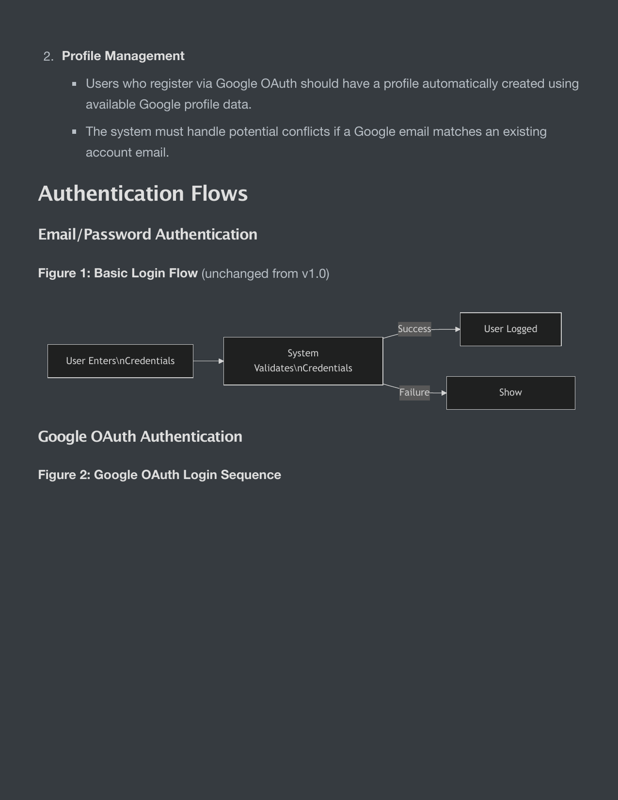


Rank 2: (Score: 0.4076)
Source: Project Phoenix User Authentication Specification v2.0_p3
Image path: temp_spec_images/Project Phoenix User Authentication Specification v2.0_p3.png


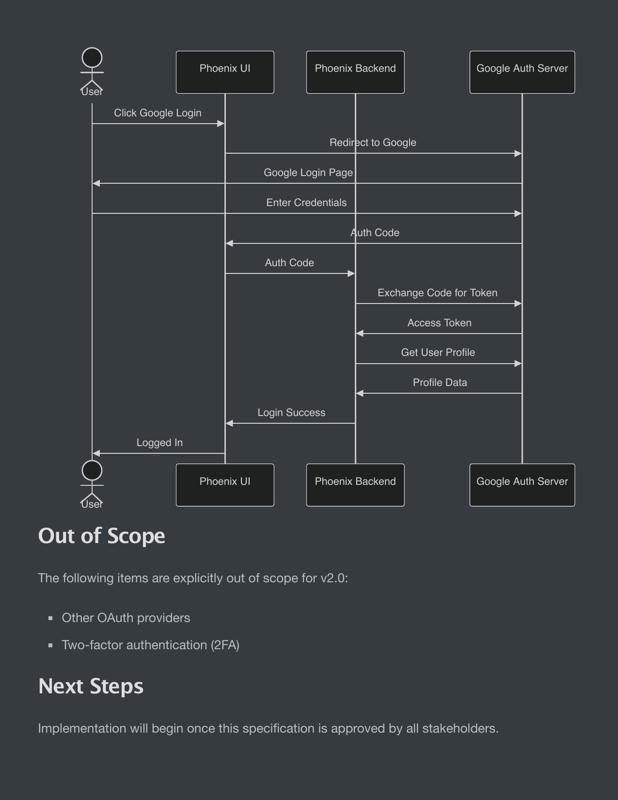


--- Searching for: 'Which spec mentions dashboard widgets?' ---
Top 1 results:

Rank 1: (Score: 0.4120)
Source: Project Sentinel User Dashboard Specification v1.0_p1
Image path: temp_spec_images/Project Sentinel User Dashboard Specification v1.0_p1.png


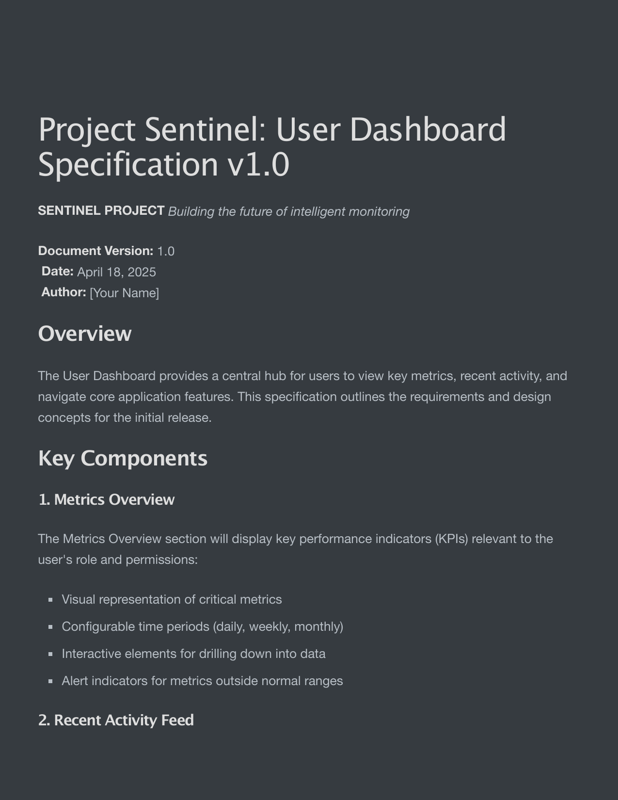


--- Searching for: 'What are Competitor A's MFA options?' ---
Top 1 results:

Rank 1: (Score: 0.3306)
Source: AuthGuard Pro™_p3
Image path: temp_spec_images/AuthGuard Pro™_p3.png


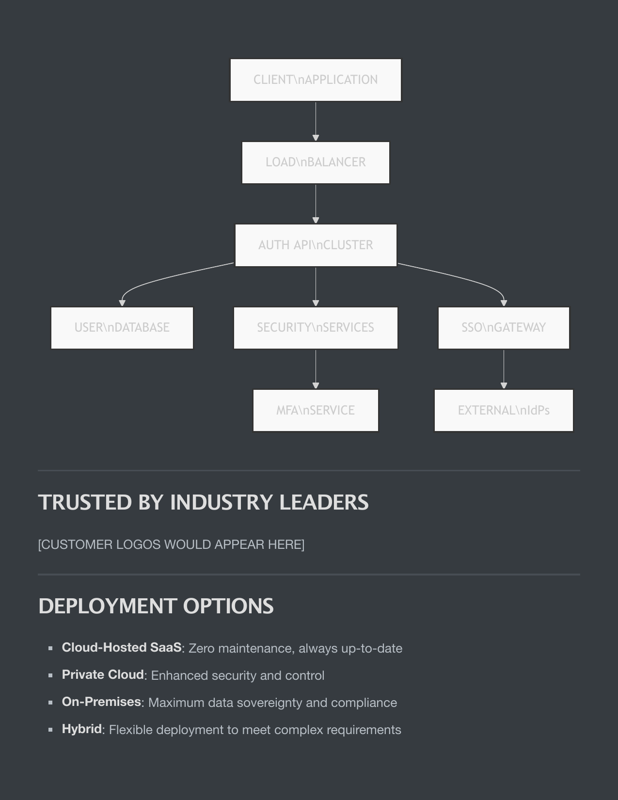


--- Searching for: 'Compare Auth v1 and v2 requirements' ---
Top 3 results:

Rank 1: (Score: 0.3728)
Source: Project Phoenix User Authentication Specification v2.0_p1
Image path: temp_spec_images/Project Phoenix User Authentication Specification v2.0_p1.png


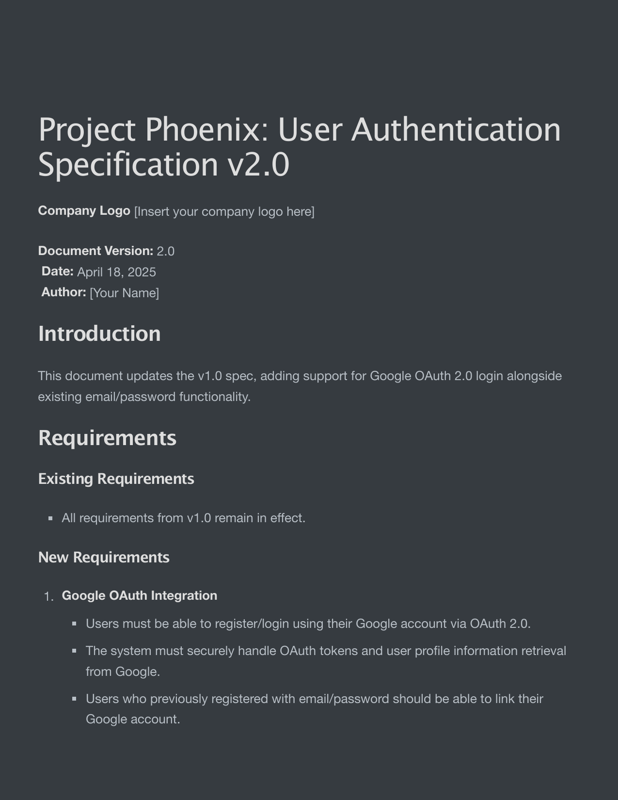


Rank 2: (Score: 0.3126)
Source: Project Phoenix User Authentication Specification v2.0_p2
Image path: temp_spec_images/Project Phoenix User Authentication Specification v2.0_p2.png


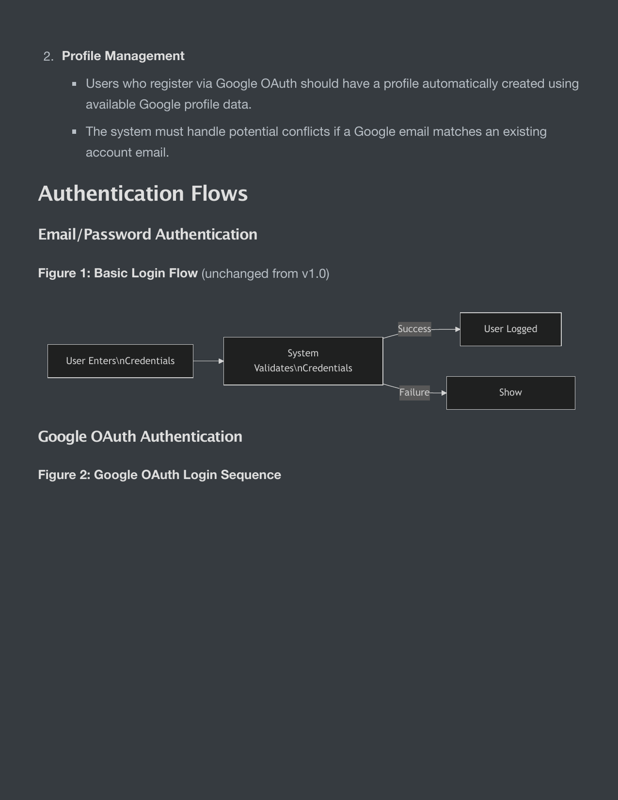


Rank 3: (Score: 0.3045)
Source: Project Phoenix User Authentication Specification v1.0_p2
Image path: temp_spec_images/Project Phoenix User Authentication Specification v1.0_p2.png


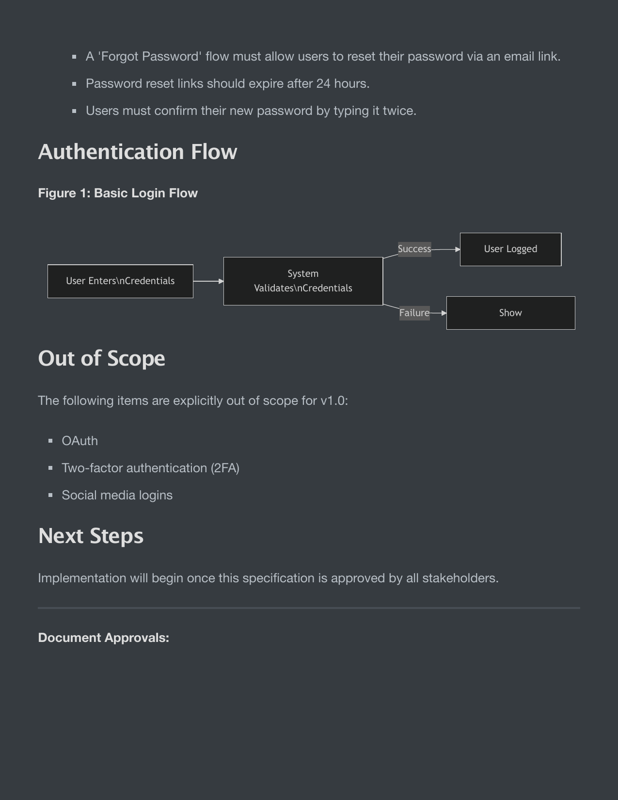


--- Searching for: 'Show competitor analytics charts' ---
Top 2 results:

Rank 1: (Score: 0.3233)
Source: Insight Hub™_p2
Image path: temp_spec_images/Insight Hub™_p2.png


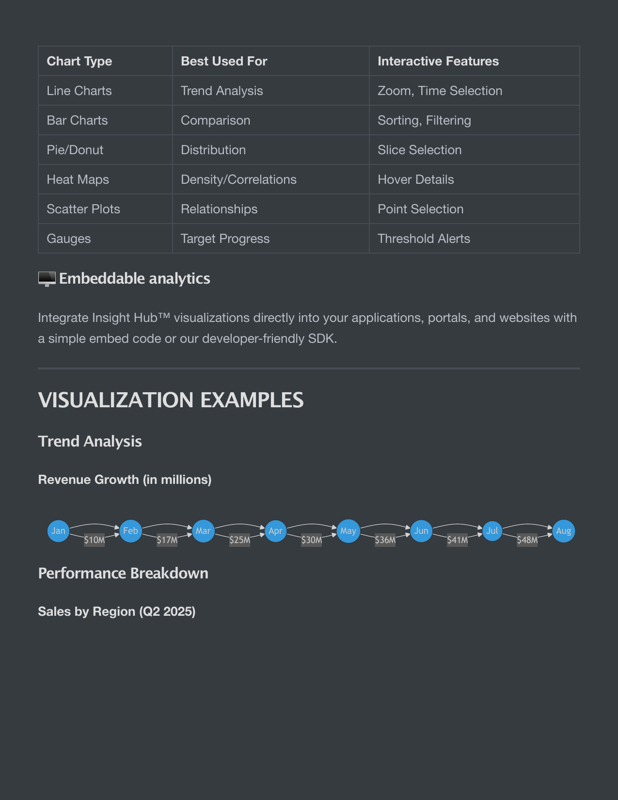


Rank 2: (Score: 0.2582)
Source: Insight Hub™_p1
Image path: temp_spec_images/Insight Hub™_p1.png


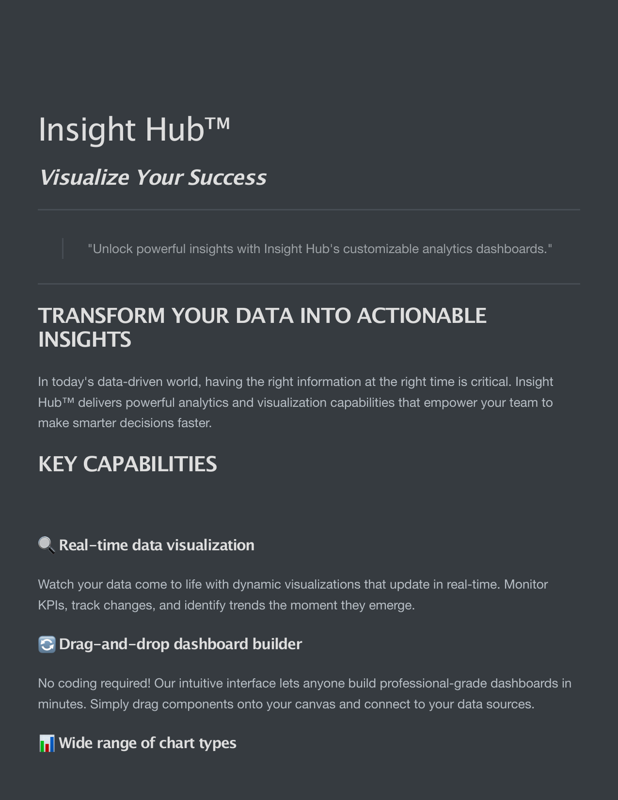


--- Searching for: 'Details about API rate limiting' ---
Top 3 results:

Rank 1: (Score: 0.4951)
Source: API Rate Limiting - Technical Specification_p2
Image path: temp_spec_images/API Rate Limiting - Technical Specification_p2.png


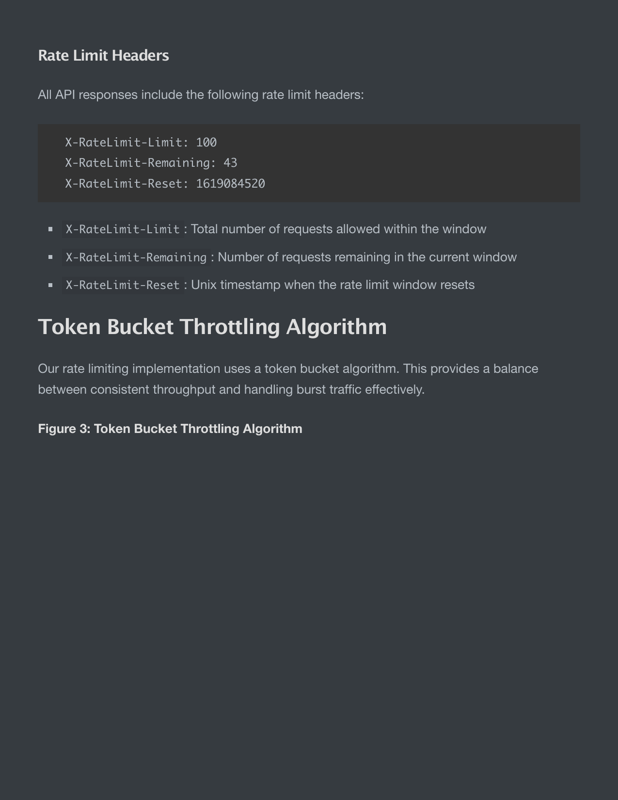


Rank 2: (Score: 0.4673)
Source: API Rate Limiting - Technical Specification_p5
Image path: temp_spec_images/API Rate Limiting - Technical Specification_p5.png


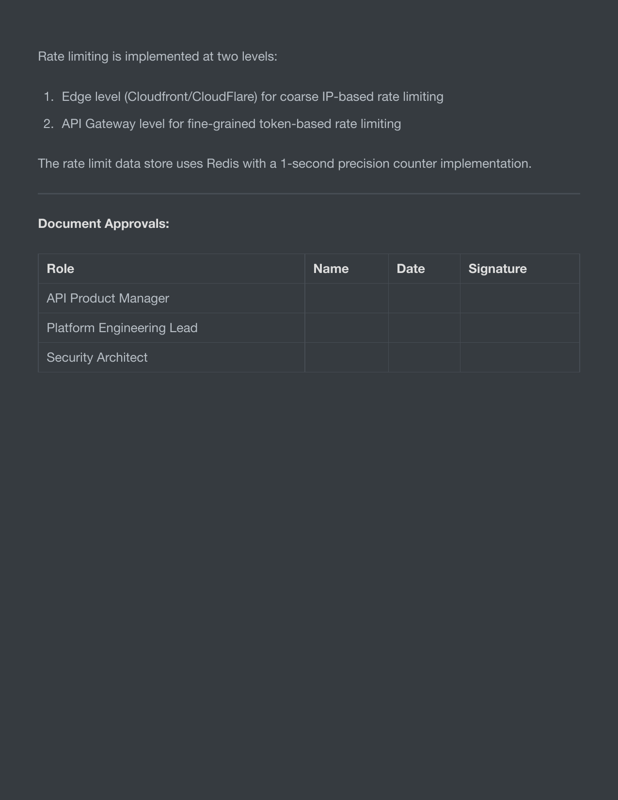


Rank 3: (Score: 0.4527)
Source: API Rate Limiting Overview_p2
Image path: temp_spec_images/API Rate Limiting Overview_p2.png


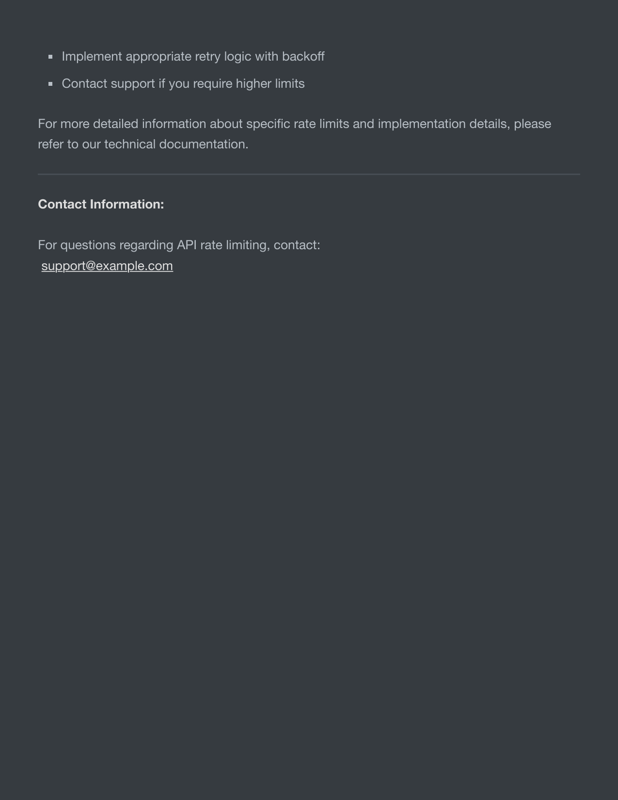

In [9]:
# --- Run Example Searches and Visualizations ---
if 'doc_embeddings' in globals() and doc_embeddings.size > 0:
    print("\n--- Running Example Searches ---")

    example_queries = [
        "Show the diagram for Google OAuth",
        "Which spec mentions dashboard widgets?",
        "What are Competitor A's MFA options?",
        "Compare Auth v1 and v2 requirements",
        "Show competitor analytics charts",
        "Details about API rate limiting"

    ]

    # Run searches with different numbers of results
    search(example_queries[0], topk=2)
    search(example_queries[1], topk=1)
    search(example_queries[2], topk=1)
    search(example_queries[3], topk=3)
    search(example_queries[4], topk=2)
    search(example_queries[5], topk=3)

else:
    print("\nSkipping searches and visualizations as document embeddings are not available.")


## Conclusion & Next Steps

This implementation demonstrates cohere's embed v4 pdf image search.

### Key Achievements:
- Extracted content from PDF documents and converted to searchable embeddings
- Implemented efficient batch processing for API usage optimization
- Created reliable similarity search with ranked results


For more information or implementation support, contact:
**Saumil Srivastava - AI Engineering Consultant**